### This script summarizes the step-by-step preprocessing of a uPBM protein experimental input

In [2]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.2 MB/s eta 0:00:00


In [24]:
import numpy as np
import pandas as pd
from Bio import pairwise2
import re
from collections import defaultdict
import random

In [11]:
protein = 'LHX9'

# We first preprocess the raw data file to extract the 35mers and intensity (we have already deleted the header)

raw_data = pd.read_csv(f'/content/GSM2479920_{protein}_RawData_Cytosine.txt', sep='\t', skiprows=53)
raw_data = raw_data.dropna(subset='Annotation 2')
raw_data = raw_data.reset_index(drop=True)
raw_data = raw_data[raw_data['Annotation 1'] != 'NoDNA']

# Extract only sequence, mean signal instensity and background instensity (Annotation 2, Signal Mean, and Background)
raw_data = pd.DataFrame(raw_data[['Annotation 2', 'Signal Mean', 'Background Mean']])
raw_data.columns = ['pbm_sequence', 'mean_signal_intensity', 'mean_background_intensity']

<ipython-input-11-1df171657189>:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(f'/content/GSM2479920_{protein}_RawData_Cytosine.txt', sep='\t', skiprows=53)


In [12]:
# Trim sequences to 35mers of interest
raw_data['pbm_sequence'] = raw_data['pbm_sequence'].str[:35]
raw_data

,pbm_sequence,mean_signal_intensity,mean_background_intensity
0,CTCTGTAAGTCAGGGTGACTCGAGCGGATCACCTG,3470.5527,2648.3959
1,AGGTGGGTCCAATTATCCGATCTCACGTCGACCTT,5054.6875,4724.4189
2,TTTTCCCCCGCTTACAGCTGGACTAAAGATCGGAA,3884.4868,4269.2802
3,CAAGTATTTTATCATTCGACAGACCCTCGGAAACT,5568.6757,4578.2788
4,TTGCCCGGTCGCACGCTGCCTGTACTCTCCGAGAT,5119.0688,1402.3364
...,...,...,...
40624,GCGCCAAGGCTTAGACCGAGCTTCACTCCTCGGGA,7154.4892,2288.3166
40625,TGGCAAGAATGCAGGTGGATTCAAGGCGCGGCTTT,7694.8188,2671.3029
40626,ACAAGTGAGTTAACTTTAGTGCGTCCCGTTATGAT,21354.3144,4581.6015
40627,CTATTGGATACGCCAGTGTTGTCAAGCCATCAGGG,7247.0209,3568.1811


##### Take the top sequences and generates a FASTA file

<ipython-input-13-b280cd8a59dd>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(matrix.iloc[i][0]) == 35:


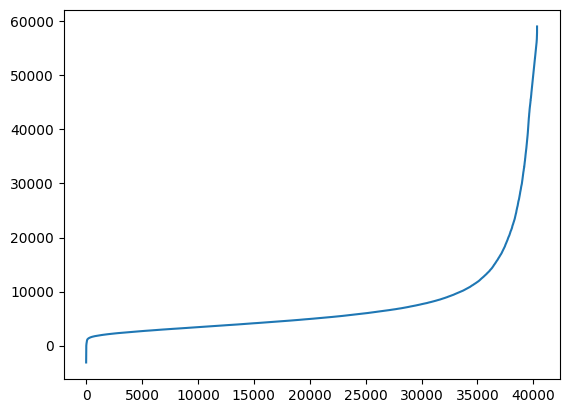

In [13]:
matrix = raw_data
matrix = matrix.dropna()

ams = []
i=0
while i<len(matrix):
    if len(matrix.iloc[i][0]) == 35:
        ams.append(matrix.iloc[i])
    i=i+1

ams = pd.DataFrame(ams)

# read all the sequences and its affinities, put them in 'sequences' (array of strings) and 'affinities' (array of doubles)
sequences=np.array(ams[["pbm_sequence"]])
affinities = np.array(ams[["mean_signal_intensity"]])-np.array(ams[["mean_background_intensity"]])
max_aff = max(affinities)[0]

### choose boundaries for undersampling and oversampling and selecting the top sequences

sort_aff = sorted(list(affinities))
# drop a fourth of the points:
lower_bound = sort_aff[int(len(sort_aff)/4)][0]
# pick top 50 points
upper_bound = sort_aff[-50][0]

with open(f'{protein}_FASTA_seq.txt','w') as file:
    for i in np.arange(0,len(sequences)):
        if affinities[i][0]>upper_bound:
            if affinities[i][0] == max_aff:
                file.write(f'>MAX\n{sequences[i][0]}\n')
                continue
            file.write(f'>{i}\n{sequences[i][0]}\n')

import matplotlib.pyplot as plt
plt.plot(sorted(list(affinities)))

In [ ]:
len(sequences)

40330

### Now the user needs to go to meme suite to extract the motif matrix

In [ ]:
# post the file (type or upload) into http://meme-suite.org/tools/meme
# choose the length of the consensus -- k=10, k=12?
# get the frequency matrix and upload it as {protein}_freq_matrix.txt

# don't forget to add the labels A C G T on each column!!

In [14]:
# reads the frequency matrix and picks the most likely sequence
freq_matrix = pd.read_csv(f'{protein}_freq_matrix.txt', delim_whitespace=True)
freq_matrix = np.array(freq_matrix)

## generates the consensus (and second sequence for oversampling if necessary)
cons = []
for i in np.arange(0,len(freq_matrix)):
    result = np.where(freq_matrix[i] == np.amax(freq_matrix[i]))
    cons.append(result[0][0])

translate = {'A':0, 'C':1, 'G':2, 'T':3}
reverse = {0:'A', 1:'C', 2:'G', 3:'T'}

seq = ''
for num in cons:
    seq = seq+reverse[num]

consensus = [seq]

'''
# second
sec = []
for i in np.arange(0,len(freq_matrix)):
    if np.amax(freq_matrix[i])<0.5:
        second = sorted(freq_matrix[i])[-2]
        result = list(freq_matrix[i]).index(second)
        sec.append(result)
        continue
    result = np.where(freq_matrix[i] == np.amax(freq_matrix[i]))
    sec.append(result[0][0])

seq = ''
for num in sec:
    seq = seq+reverse[num]

consensus.append(seq)
'''
consensus

<ipython-input-14-e2c0add57311>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  freq_matrix = pd.read_csv(f'{protein}_freq_matrix.txt', delim_whitespace=True)


['TAATTAG']

In [15]:
max_aff = max(affinities)[0]
min_aff = min(affinities)[0]
normalization = max_aff-min_aff

In [16]:
# define a new function: best alignment between the consensus and a sequence from the 35mers

def comp(seq):
  """
  just the complementary seq-generating function
  """
  wc = {"A":"T", "T":"A", "C":"G", "G":"C"}
  return ''.join([wc[x] for x in seq[::-1]])

def alignment(seq,aln):
    if pairwise2.align.localms(seq, comp(aln), 1, 0, -9999, -9999)[0][2] > pairwise2.align.localms(seq, aln, 1, 0, -9999, -9999)[0][2]:
        fst, snd, scx, *q = pairwise2.align.localms(seq, comp(aln), 24, -12, -9999, -9999)[0]
        aligned = (''.join([fst[n] for n, i in enumerate(fst) if snd[n] != '-']))
        aligned = re.sub('-','', aligned)
    else:
        fst, snd, scx, *q = pairwise2.align.localms(seq, aln, 24, -12, -9999, -9999)[0]
        aligned = (''.join([fst[n] for n, i in enumerate(fst) if snd[n] != '-']))
        aligned = re.sub('-','', aligned)
    return aligned


# generates the file matching the sequences with the consensus sequence(s)

len_aln = len(consensus[0])

fst_aln = consensus[0]

to_write = []
for seq, aff in zip(sequences, affinities):
    s_1 = alignment(seq[0],fst_aln)
    if len(s_1) != len_aln:
        continue
    if aff[0]<lower_bound:
        continue
    score = pairwise2.align.localms(s_1, fst_aln, 1, 0, -9999, -9999)[0][2]
    if pairwise2.align.localms(s_1, comp(fst_aln), 1, 0, -9999, -9999)[0][2] > pairwise2.align.localms(s_1, fst_aln, 1, 0, -9999, -9999)[0][2]:
        score = pairwise2.align.localms(s_1, comp(fst_aln), 1, 0, -9999, -9999)[0][2]
        s_1 = comp(s_1)
    if score<len_aln-3:
        w=1
    if score>=len_aln-3:
        w=10
    to_write.append((s_1, (aff[0]-min_aff)/normalization, w))

if len(consensus) != 1:
    snd_aln = consensus[1]
    for seq, aff in zip(sequences, affinities):
        s_2 = alignment(seq[0],snd_aln)
        if len(s_2) != len_aln:
            continue
        if aff<upper_bound:
            continue
        a = aff[0]-0.0001
        score = pairwise2.align.localms(s_2, snd_aln, 1, 0, -9999, -9999)[0][2]
        if pairwise2.align.localms(s_2, comp(snd_aln), 1, 0, -9999, -9999)[0][2] > pairwise2.align.localms(s_2, snd_aln, 1, 0, -9999, -9999)[0][2]:
            score = pairwise2.align.localms(s_2, comp(snd_aln), 1, 0, -9999, -9999)[0][2]
            s_2 = comp(s_2)
        if score<len_aln-3:
            w=1
        if score>=len_aln-3:
            w=10
        to_write.append((s_2, aff[0], w))


with open(f'{protein}_alignment_weighted.txt','w') as file:
    file.write('ID_REF\tVALUE\tWEIGHT\n')

with open(f'{protein}_alignment_weighted.txt','a') as file:
    for i in to_write:
        file.write(f'{i[0]}\t{i[1]}\t{i[2]}\n')

In [22]:
# from the previous file (the file of nicely aligned kmers), we remove those that have low score according to the freq matrix
data = pd.read_csv(f'{protein}_alignment_weighted.txt', sep='\t')
dodecamers = np.array(data[["ID_REF"]])
affs = np.array(data[["VALUE"]])
ws = np.array(data[["WEIGHT"]])

freq_matrix = pd.read_csv(f'{protein}_freq_matrix.txt', delim_whitespace=True)
freq_matrix = np.array(freq_matrix)

# scores
scores = []
for dod in dodecamers:
    score = 0
    for j in np.arange(0,len_aln):
        a = translate[dod[0][j]]
        score = score + freq_matrix[j][a]
    scores.append(score)

# boundaries
low_score = len_aln/4
upp_score = sorted(scores)[::-1][50]

# file
to_write = []

for dod, aff, w, score in zip(dodecamers, affs, ws, scores):
    if score<low_score:
        continue
    if score<upp_score:
        #to_write.append((dod[0],aff[0], w[0], score, 1))
        to_write.append((dod[0],aff[0], 1))
    if score>upp_score:
#        to_write.append((dod[0],aff[0], w[0], score, 10))
        to_write.append((dod[0],aff[0], 10))
with open(f'/content/{protein}_matrix_aligned.txt','w') as file:
#    file.write('ID_REF\tVALUE\tWEIGHT\tSCORE\tWEIGHTEDSCORE\n')
    file.write('ID_REF\tVALUE\tWEIGHT\n')

with open(f'/content/{protein}_matrix_aligned.txt','a') as file:
    for i in to_write:
#        file.write(f'{i[0]}\t{i[1]}\t{i[2]}\t{i[3]}\t{i[4]}\n')
        file.write(f'{i[0]}\t{i[1]}\t{i[2]}\n')

<ipython-input-22-4df31829dbcb>:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  freq_matrix = pd.read_csv(f'{protein}_freq_matrix.txt', delim_whitespace=True)


In [23]:
deca = pd.read_csv(f'/content/{protein}_matrix_aligned.txt', sep='\t')

strings = list(deca["ID_REF"])
values = list(deca["VALUE"])
weights = list(deca["WEIGHT"])  # pick either WEIGHT or WEIGHTEDSCORE

values = [(value-min(values))/(max(values)-min(values)) for value in values]

dictionary = dict(zip(values, strings))
weight_dict = dict(zip(values, weights))

len_aln = len(strings[0])

#### Last step, we undersample

In [25]:
#### undersampling

# number of divisions we are using
L = 25000

# affinitiy boundaries
sort_aff = sorted(values)
# pick top points ~ proportion 1:500 before undersampling i.e. we pick 50 top points not to undersample
upper_bound = sort_aff[-1000]

# interval dictionary -- maybe it is not the best option? idk it works for now...
interval_dict = defaultdict(list)
for value in values:
    interval_dict[int(value*L)].append(value)

# creates a matrix of values: we pick one value for the intervals where i<L/2
# and up to two for i>L/2

training_ordered = []
start = 1 # i.e. starts picking values larger than start/L from the normalized affinites

for i in np.arange(start,L+1):
    if len(interval_dict[i])>0:
        if i <= L*upper_bound:
            random_values = [random.choice(interval_dict[i]) for j in np.arange(0,20)]
            random_values = set(random_values)
            value = random.choice(interval_dict[i])
            training_ordered.append([dictionary[value], value, weight_dict[value]])
        if i > L*upper_bound:
            for value in interval_dict[i]:
                training_ordered.append([dictionary[value], value, weight_dict[value]])

# # writes the file w/o randomization (not used but in case we need it)

# with open(f'{protein}_training_ordered.txt','w') as file:
#     file.write('ID_REF\tVALUE\tWEIGHT\n')

# with open(f'{protein}_training_ordered.txt','a') as file:
#     for vector in training_ordered:
#         file.write("%s\t" % vector[0])
#         file.write("%s\t" % vector[1])
#         file.write("%s\n" % vector[2])

# writes the randomized file ready for training

np.random.shuffle(training_ordered)

with open(f'{protein}_training.txt','w') as file:
    file.write('ID_REF\tVALUE\tWEIGHT\n')

with open(f'{protein}_training.txt','a') as file:
    for vector in training_ordered:
        file.write("%s\t" % vector[0])
        file.write("%s\t" % vector[1])
        file.write("%s\n" % vector[2])
